# Probit regression

Testing probit regression with identity covariance

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from time import time

import cvxpy as cv
from statsmodels.discrete.discrete_model import Probit
import sklearn.linear_model as linear_model
from scipy.special import erfcinv

from state_evolution.models.probit_regression import ProbitRegression # logistic regression task
from state_evolution.models.logistic_regression import LogisticRegression # logistic regression task
from state_evolution.models.bayes_optimal_probit import BayesOptimalProbit
from state_evolution.algorithms.state_evolution import StateEvolution # Standard SP iteration
from state_evolution.auxiliary.utility import *
from state_evolution.data_models.custom import Custom # Custom data model. You input the covariances

sys.path.append('../overparametrized-uncertainty/Code')
import core.data as data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
d = 256

# Covariances

Omega = Psi = Phi = np.eye(d)

# Teacher weights
theta = np.random.multivariate_normal(mean=np.zeros(d), cov=np.eye(d))
# NORMALIZE THE TEACHER FOR BETTER RESULTS
theta = np.sqrt(d) * theta / np.linalg.norm(theta)

In [152]:
alpha = 20.0
sigma = 0.5

w0, X, y = data.ProbitModelData(covariance = Omega, teacher_covariance = np.eye(d), sigma = sigma).sample_instance(alpha)
y_probit = (y + 1) / 2.0

data_model = Custom(teacher_teacher_cov = Psi,
                    student_student_cov = Omega,
                    teacher_student_cov = Phi,
                    teacher_weights     = theta)

In [153]:
task = ProbitRegression(sample_complexity = alpha,
                        regularisation    = 0.0,
                        data_model        = data_model,
                        Delta             = sigma**2)

sp = StateEvolution(model = task,
                    initialisation = 'uninformed',
                    tolerance = 1e-7,
                    damping = 0.5,
                    verbose = False,
                    max_steps = 1000)

sp.iterate()

In [159]:
# empirical probit 

w = cv.Variable(d)
error = - cv.sum(cv.log_normcdf( cv.multiply(y, X @ w) ))
obj = cv.Minimize(error)
prob = cv.Problem(obj)
prob.solve()

3083.8117248929075

In [155]:
print('For PROBIT : ')

info = sp.get_info()
print('theory : q = ', info['overlaps']['self_overlap'],', m = ', info['overlaps']['teacher_student'])

exp_q = np.mean(weight * weight)
exp_m = np.mean(weight * w0)
exp_rho = np.mean(w0 * w0)
print(f'experiment : q = {exp_q}, m = {exp_m}')
print('theoretical angle : ', info['overlaps']['teacher_student'] / (np.sqrt(info['overlaps']['self_overlap'])))
print('experimental angle : ', exp_m / np.sqrt(exp_q * exp_rho))

For PROBIT : 
theory : q =  330.3999562364363 , m =  15.906902070370299
experiment : q = 6.630966696098538, m = -0.051097122114033604
theoretical angle :  0.8751159850345857
experimental angle :  -0.020010285123465917


In [156]:
lr_lambda_ = 0.0    

lr_task = LogisticRegression(sample_complexity = alpha,
                        regularisation    = lr_lambda_,
                        data_model        = data_model,
                        Delta             = sigma**2)

lr_sp = StateEvolution(model = lr_task,
                    initialisation = 'uninformed',
                    tolerance = 1e-7,
                    damping = 0.5,
                    verbose = False,
                    max_steps = 1000)
lr_sp.iterate()

if lr_lambda_ > 0.0:
    lr = linear_model.LogisticRegression('l2', C=1. / lr_lambda_, fit_intercept=False)
else:
    lr = linear_model.LogisticRegression('none', fit_intercept=False)
lr.fit(X, y)

LogisticRegression(fit_intercept=False, penalty='none')

In [157]:
print('====')
print('For LOGISTIC')

lr_info = lr_sp.get_info()
print('theory : q = ', lr_info['overlaps']['self_overlap'],', m = ', lr_info['overlaps']['teacher_student'])
exp_q = np.mean(lr.coef_ * lr.coef_)
exp_m = np.mean(w0 * lr.coef_)
print(f'experiment : q = {exp_q}, m = {exp_m}')

print('theoretical angle : ', lr_info['overlaps']['teacher_student'] / (np.sqrt(lr_info['overlaps']['self_overlap'])))
print('experimental angle : ', exp_m / np.sqrt(exp_q))

====
For LOGISTIC
theory : q =  15.78257944353744 , m =  3.8882932630945053
experiment : q = 14.939757993481116, m = 3.7450653363764443
theoretical angle :  0.978746046576708
experimental angle :  0.9689193241261174


### Running as a function of alpha 

Fix the level, compute the calibration

In [111]:
p = 0.75
inv_p = - np.sqrt(2) * erfcinv(2 * p)

alpha_range  = np.linspace(10.0, 1000.0, 20)
calibrations = []

for alpha in alpha_range:
    print(alpha)
    task = ProbitRegression(sample_complexity = alpha,
#     task = LogisticRegression(sample_complexity = alpha,
                            regularisation    = 0.0,
                            data_model        = data_model,
                            Delta             = sigma**2)

    sp = StateEvolution(model = task,
                        initialisation = 'uninformed',
                        tolerance = 1e-7,
                        damping = 0.5,
                        verbose = False,
                        max_steps = 1000)

    sp.iterate()
    info = sp.get_info()
    
    m, q, rho = info['overlaps']['teacher_student'], info['overlaps']['self_overlap'], 1.0
    print(f'm = {m}, q = {q}, angle = {m / np.sqrt(q)}')
    calibrations.append(
         0.5 * erfc(- (m / q * inv_p) / np.sqrt(2*(rho - m**2 / q + sigma**2)))
    )
    print('Calibration : ', calibrations[-1])

10.0


/Users/clarte/Code/GCMProject/state_evolution/auxiliary/probit_integrals.py:19: RuntimeWarning: divide by zero encountered in log
  return - np.log(cdf(z))
/Users/clarte/anaconda3/envs/ml/lib/python3.9/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


m = 17.518558000798812, q = 400.12780941277646, angle = 0.8757879937783819
Calibration :  0.5169466114737635
62.10526315789474
m = 25.69406499603228, q = 926.9960777430069, angle = 0.8439056025270398
Calibration :  0.5101688884941326
114.21052631578948
m = 12.241209751920792, q = 185.75250146079594, angle = 0.898166813298956
Calibration :  0.5266137143411115
166.31578947368422
m = 13.293050220515795, q = 222.17264582920268, angle = 0.8918244034242699
Calibration :  0.5238628342759093
218.42105263157896
m = 13.91934623398257, q = 245.55495903203476, angle = 0.8882689536710787
Calibration :  0.522453592682079
270.5263157894737
m = 14.334356468900083, q = 261.7511041068463, angle = 0.8860004433976055
Calibration :  0.5215990567476354
322.63157894736844
m = 14.629415699392823, q = 273.6076541722445, angle = 0.8844287657041191
Calibration :  0.521026134998451
374.7368421052632
m = 14.849906418894726, q = 282.6535536167364, angle = 0.8832761255464706
Calibration :  0.520615505769896
426.8421

### Some plots

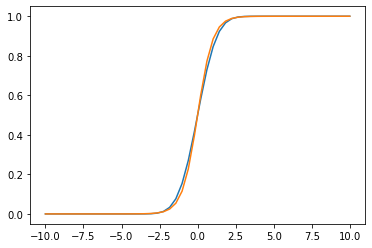

In [110]:
def cdf(x):
    return 0.5 * erfc(- x / np.sqrt(2.0))

def logistic(x):
    return 1. / (1 + np.exp(-2.*x))

vals = np.linspace(-10.0, 10.0, 50)
plt.plot(vals, cdf(vals))
plt.plot(vals, logistic(vals))